In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report)

In [10]:
df = pd.read_csv("income.csv")
df_sampled = df.sample(n=10000, random_state=42).reset_index(drop=True)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [4]:
df_sampled['income'] = df_sampled['income'].str.strip()
df_clean = df_sampled[df_sampled['income'].isin(['<=50K', '>50K'])].copy()

categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')
imputer = SimpleImputer(strategy='most_frequent')
df_clean[categorical_cols] = imputer.fit_transform(df_clean[categorical_cols])

label_encoder = LabelEncoder()
df_clean['income'] = label_encoder.fit_transform(df_clean['income'])

In [6]:
X = df_clean.drop('income', axis=1)
y = df_clean['income']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
models = {
    "Random Forest (Bagging)": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost (Boosting)": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

In [13]:
def evaluate_model(name, model, X_test, y_test, y_pred, y_prob):
    print(f"Model: {name}")
    print("Akurasi     :", accuracy_score(y_test, y_pred))
    print("Presisi     :", precision_score(y_test, y_pred))
    print("Recall      :", recall_score(y_test, y_pred))
    print("F1-Score    :", f1_score(y_test, y_pred))
    print("AUC         :", roc_auc_score(y_test, y_prob))
    print("--------------------------------------------------")

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})")


Model: Random Forest (Bagging)
Akurasi     : 0.8601503759398497
Presisi     : 0.7577092511013216
Recall      : 0.5676567656765676
F1-Score    : 0.6490566037735849
AUC         : 0.8972462971710997
--------------------------------------------------
Model: AdaBoost (Boosting)
Akurasi     : 0.8609022556390977
Presisi     : 0.7681818181818182
Recall      : 0.5577557755775577
F1-Score    : 0.6462715105162524
AUC         : 0.9077112677187875
--------------------------------------------------
Model: Gradient Boosting
Akurasi     : 0.8646616541353384
Presisi     : 0.783410138248848
Recall      : 0.5610561056105611
F1-Score    : 0.6538461538461539
AUC         : 0.9130827396274195
--------------------------------------------------


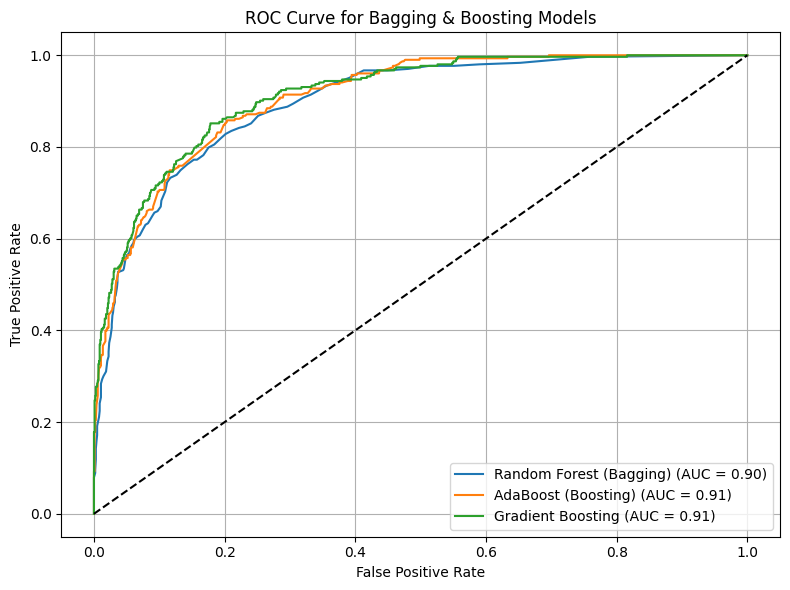

In [14]:
# Evaluasi semua model
plt.figure(figsize=(8, 6))
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    evaluate_model(name, model, X_test, y_test, y_pred, y_prob)

# Finalisasi plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Bagging & Boosting Models")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


# 📊 Evaluasi Model Machine Learning: Penjelasan & Rumus

##  1. Accuracy
**Definisi:** Proporsi prediksi yang benar dari seluruh prediksi.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

**Kelebihan:** Baik digunakan jika kelas seimbang.

**Kelemahan:** Bisa menyesatkan jika data tidak seimbang (misal: banyak lebih banyak pasien sehat daripada yang sakit).

---

##  2. Precision
**Definisi:** Proporsi prediksi positif yang benar-benar positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

**Interpretasi:** Dari semua yang diprediksi **positif (sakit jantung)**, berapa banyak yang benar-benar sakit.

**Kapan penting?** Saat **false positive** harus dihindari, seperti jika tindakan lanjutan (misalnya operasi) mahal atau berisiko.

---

##  3. Recall (Sensitivity / True Positive Rate)
**Definisi:** Proporsi kasus positif yang berhasil ditemukan model.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

**Interpretasi:** Dari semua yang **benar-benar sakit**, berapa banyak yang berhasil dideteksi.

**Kapan penting?** Sangat penting dalam **diagnosis medis**, karena kita ingin **meminimalkan False Negative** (orang sakit yang tidak terdeteksi).

---

##  4. F1-Score
**Definisi:** Rata-rata harmonik dari Precision dan Recall.

$$
\text{F1\text{-}Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Kelebihan:** Memberikan keseimbangan antara Precision dan Recall. Ideal ketika kita ingin mempertimbangkan keduanya secara seimbang.

---

## 
 5. ROC AUC (Receiver Operating Characteristic - Area Under Curve)
**Definisi:** Luas di bawah kurva ROC yang menggambarkan trade-off antara True Positive Rate dan False Positive Rate.

$$
\text{ROC AUC} = \int_{0}^{1} TPR(FPR) \, dFPR
$$

**Interpretasi:** Probabilitas bahwa model memberi skor lebih tinggi pada pasien positif daripada pasien negatif.

**Nilai:**
- 0.5 = seperti tebak-tebakan
- 1.0 = sempurna
- > 0.9 = sangat baik

---
